# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [436]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'seaborn-paper', 'bmh', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [437]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

w -- веса (коэфициенты)

b -- bias (intersept)

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [415]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [416]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [417]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

In [418]:
from sklearn.model_selection import train_test_split

In [419]:
# разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fitting a model
LR = lm.LinearRegression()
LR.fit(X_train, y_train)

# predict на всей выборке X
y_pred = LR.predict(X)
# predict на test 
y_pred = LR.predict(X_test)

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [420]:
err = []
LRs = []
for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    LR.fit(X_train, y_train)
    # predict на всей выборке X
    y_pred = LR.predict(X)
    err.append(np.mean((y - y_pred)**2))
    LRs.append(LR)

Код для построения графиков:

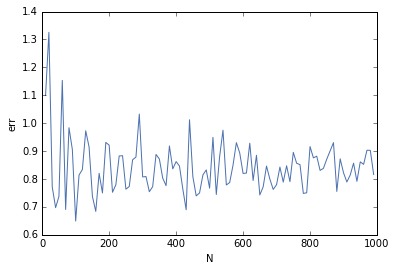

In [438]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

При размере выборки > 400 регрессионная прямая перестаёт быть визуально отличимой от истинной.

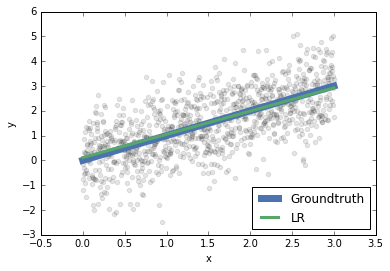

In [439]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=7)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Проделайте тоже самое для KNN при n_neighbors=3.

In [423]:
from sklearn.neighbors import KNeighborsRegressor

In [424]:
err = []
KNNs = []

for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    KNN = KNeighborsRegressor(n_neighbors=3)
    KNN.fit(X_train, y_train)
    # predict на всей выборке X
    y_pred = KNN.predict(X)
    err.append(np.mean((y - y_pred)**2))
    KNNs.append(KNN)

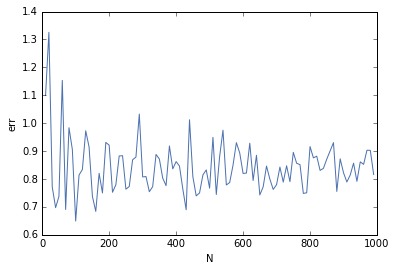

In [440]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

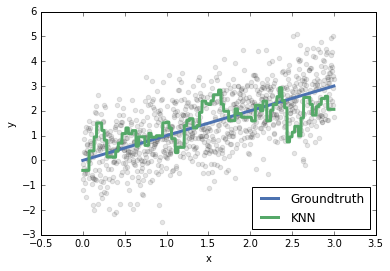

In [441]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличьте число соседей до 10 и проделайте тоже самое.

In [443]:
err = []
KNNs = []

for N in N_grid[1:]:
    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    KNN = KNeighborsRegressor(n_neighbors=10)
    KNN.fit(X_train, y_train)
    # predict на всей выборке X
    y_pred = KNN.predict(X)
    err.append(np.mean((y - y_pred)**2))
    KNNs.append(KNN)

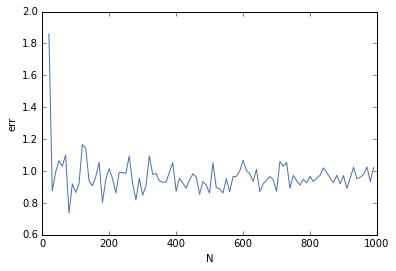

In [444]:
plt.plot(range(20, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

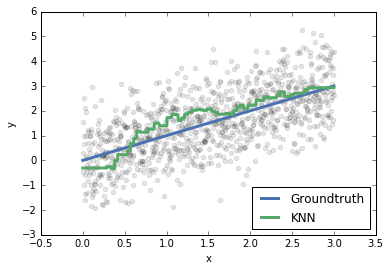

In [445]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

__Итог:__ Квадраты ошибок лучше всего минимизирует knn с 3 соседями (хотя дисперсия квадратов ошибок у knn-3 больше), но его оценка модели хуже (=сильнее отличается от истинного тренда) оценки модели, произведенной с помощью knn c 10 соседями. Тем не менее, оценка модели простой линейной регрессией практически неотличима от истинного тренда, хотя ее квадраты ошибок в среднем больше квадратов ошибок других методов. 

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        Poly = pp.PolynomialFeatures(degree=d_new)
        X_new = Poly.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [453]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [454]:
err_1 = []
LRs_1 = []
for N in N_grid:
    LR = lm.LinearRegression()
    X, y, y_gt = gen_data(N, 1, 1, 10, f_target, f_noise)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    LR.fit(X_train, y_train) # fit
    y_pred_1 = LR.predict(X) # predict
    err_1.append(np.mean((y - y_pred_1)**2))
    LRs_1.append(LR)


err_2 = []
LRs_2 = []
Poly = pp.PolynomialFeatures(degree=2)
for N in N_grid:
    LR = lm.LinearRegression()
    X, y, y_gt = gen_data(N, 1, 1, 10, f_target, f_noise)
    X_new_2 = Poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_new_2, y)
    LR.fit(X_train, y_train)
    y_pred_2 = LR.predict(X_new_2)
    err_2.append(np.mean((y - y_pred_2)**2))
    LRs_2.append(LR)

    
err_3 = []
LRs_3 = []
Poly = pp.PolynomialFeatures(degree=5)
for N in N_grid:
    LR = lm.LinearRegression()
    X, y, y_gt = gen_data(N, 1, 1, 10, f_target, f_noise)
    X_new_3 = Poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_new_3, y)
    LR.fit(X_train, y_train)
    y_pred_3 = LR.predict(X_new_3)
    err_3.append(np.mean((y - y_pred_3)**2))
    LRs_3.append(LR)

Код для построения всех графиков:

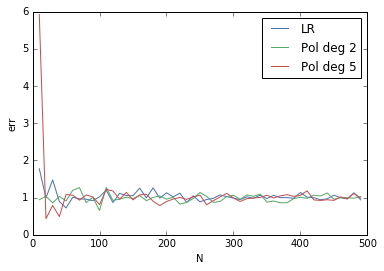

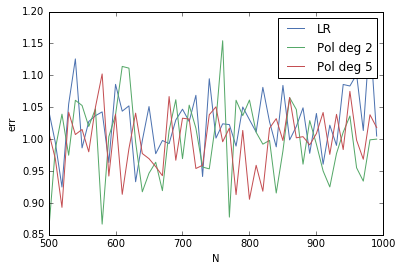

In [455]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

Чем больше выборка, тем меньше разброс ошибок. Для всех моделей среднее ошибки = 1.

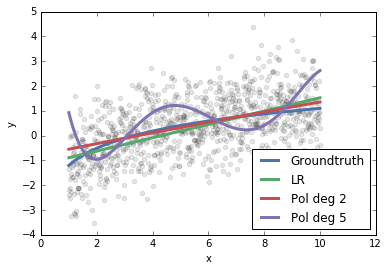

In [456]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

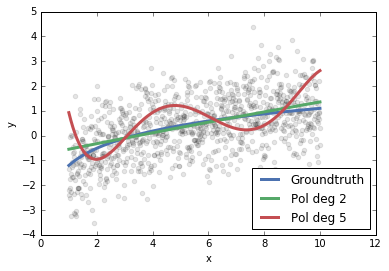

In [457]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

__Итог:__ Лучше всех приближает даннные полиномиальная кривая степени 5, поскольку это переобученная модель. Истинный тренд лучше всего показывает полиномиальная кривая 2 степени, у нее же наибольшая дисперсия ошибок среди остальных моделей. 

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = Ridge.predict(X_train)

In [471]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.01, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.25, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [472]:
# fitting a simple regression
LR = lm.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X)

# fitting a Ridge regression
Ridge = lm.Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y)
Ridge.fit(X_train, y_train)
y_pred_Ridge = Ridge.predict(X)

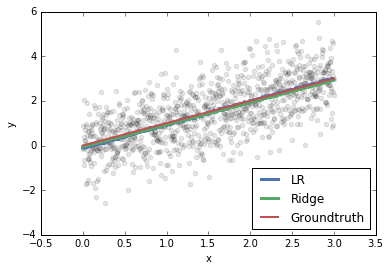

In [473]:
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

_График_: Обе регрессии одинаково приближают данные и неотличимы от истинного тренда. 

График для разности предсказанных ответов и истинных:

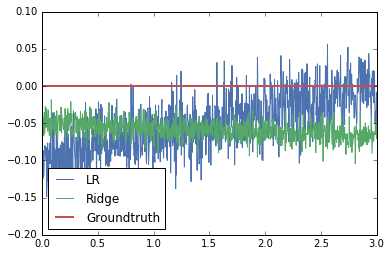

In [474]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

_График_: Ошибки ридж-регрессии фиксированны: их среднее = -0.5 (наблюдаем гомоскедастичность). У обычной линейной регрессии ошибки распределены "по наклонной прямой", то есть скорее гетероскедастичны. Дисперсия ошибок у ридж меньше, чем у обычной регрессии. 

In [475]:
print(np.sum((y_pred_LR - y_gt)**2)) 
print(np.sum((y_pred_Ridge - y_gt)**2))

4.10472180787
3.61494449399


Сумма квадратов ошибок у ридж-регрессии меньше, то есть она лучше справляется с задачей минимизации ошибок.

In [476]:
print(LR.coef_)
print(Ridge.coef_)

[[ 6.59882172 -2.76112186 -0.01491796]]
[[ 0.1762437   0.34683184  0.04152627]]


__Итог:__ Веса параметров не критически отличаются между моделями, значит, мультиколлинеарность отсутствует (ридж-регрессия борется с ней). То есть ридж-регрессия не дает лучших оценок по сравнению с обычной линейной регрессией. Соответственно, нет смысла использовать ридж-регрессию, можно производить оценку с помощью обычной линейной регресии. 

#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = Lasso.predict(X_train)

In [477]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.01, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.25, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [478]:
Ridge = lm.Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y)
Ridge.fit(X_train, y_train)

Lasso = lm.Lasso()
X_train, X_test, y_train, y_test = train_test_split(X, y)
Lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [479]:
print(Lasso.coef_)
print(Ridge.coef_)

[ 0.          0.          0.18060309  0.        ]
[[ 0.27667898  1.08879625  0.36631626 -0.16138932]]


Lasso обнуляет веса при скоррелированных параметрах (= производит отбор оптимальных признаков; = уменьшает размерность данных), Ridge этого не делает, но в целом просто уменьшает веса скоррелированных параметров. 

Поскольку часть коэффициентов Lasso обнулила, в данных присутсвует мультиколлинеарность. 

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [79]:
import pandas as pd

In [229]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [230]:
data = data.iloc[:,5:]

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

In [91]:
import seaborn as sns

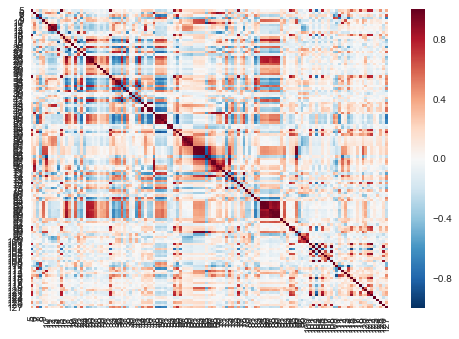

In [232]:
sns.heatmap(data.corr())

Коррелирующие признаки уменьшают точность предсказаний модели, делают среднеквадратичные ошибки и их дисперсии больше. 

К тому же мультиколлинеарность приводит к бесконечному количеству решений (так как матрицы в данном случае будут необратимы) и некоторые алгоритмы, основанные на матричных вычислениях, могут не сойтись (поэтому градиентный спуск выигрывает -- основан на оптимизации функций, сходится). Например, так проихсодит в R при оценке с помощью OLS модели с сильно скорреливаронными параметрами -- error occurs. 

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

In [379]:
# значения целевой переменной лежат в последнем столбце датафрейма

corr_matrix = data.corr()
print(sorted(corr_matrix.iloc[:, -1])[0], sorted(corr_matrix.iloc[:, -1])[-2])

-0.73842380207 0.737956549859


In [380]:
y_corr = list(corr_matrix.iloc[:, -1])

In [381]:
# getting an index of the highest negatively correlated variable with y
y_corr.index(sorted(corr_matrix.iloc[:, -1])[0]) 

44

In [382]:
# getting an index of the highest positevely correlated variable with y
y_corr.index(sorted(corr_matrix.iloc[:, -1])[-2]) 

50

Соответственно, 44 и 50 столбцы в 'data' (с пропущенными 5 первыми столбцами) сильно скорелированны с целевой переменной. 

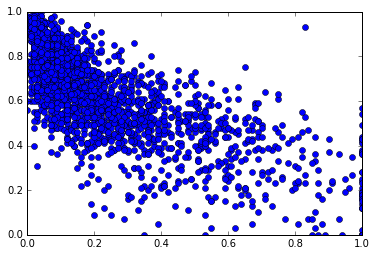

In [545]:
# the highest positevely correlated variable with y
plt.plot(data.iloc[:, -1], data.iloc[:, 44], 'bo')

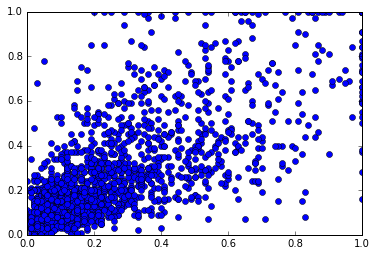

In [546]:
# the highest negatively correlated variable with y
plt.plot(data.iloc[:, -1], data.iloc[:, 50], 'bo')

#### 3. Постройте гистограмму распределения предсказываемого значения.

(array([ 679.,  470.,  305.,  154.,   97.,  107.,   66.,   26.,   33.,   57.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

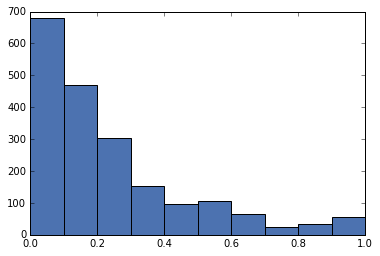

In [544]:
plt.hist(data.iloc[:, -1])

Целевая переменная имеет экспоненциальное распределение. 

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [241]:
data = data.fillna(data.mean())

Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество (Три части необходимы для бонусной части) В базовой части GridSearchCV необходимо делать на (X_train_new, y_train_new)

In [243]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [499]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1] # true values
y_test = data_test.iloc[:,-1]

In [500]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [547]:
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [548]:
y_pred = LR.predict(X_test)

In [549]:
(sum((y_pred - y_test)**2))/len(y_pred)

0.023379349302105286

#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [280]:
from sklearn.model_selection import GridSearchCV

In [551]:
from sklearn.linear_model import Ridge, Lasso

__Ridge__. L2 regularization

In [552]:
rid = Ridge()

# делаем grid search для гиперпараметра
alphas = np.logspace(-6, -1, 10) # определяем возможные значения гиперпараметра
my_ridge = GridSearchCV(rid, param_grid = {'alpha' : alphas}) # определяем grid search
my_ridge.fit(X_validate, y_validate) # grid search на validate выборке

my_ridge.best_params_ # коллим лучший гиперпараметр

# фитим модель с найденным лучишим гиперпараметром
rid = Ridge(alpha = .1) # подставляем найденный лучший гиперпараметр
rid.fit(X_train_new, y_train_new)

y_pred_ridge = rid.predict(X_test)

ridgeGOF1 = sum((y_test - y_pred_ridge)**2)/y_test.shape[0] 
ridgeGOF1

0.021333521289836378

__Lasso__. L1 regularization

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [553]:
lass = Lasso()

# делаем grid search для гиперпараметра
alphas = np.logspace(-6, -1, 10) 
my_lass = GridSearchCV(lass, param_grid = {'alpha': alphas}) 
my_lass.fit(X_validate, y_validate) 

my_lass.best_params_ # коллим лучший гиперпараметр

# фитим модель с найденным лучишим гиперпараметром
lass = Lasso(alpha = 0.00215)
lass.fit(X_train_new, y_train_new)

y_pred_lass = lass.predict(X_test)

lassoGOF1 = sum((y_test - y_pred_lass)**2)/y_test.shape[0]
lassoGOF1

0.02071332698279334

__Итог__: наилучшее качество предсказаний у Lasso, наихудшее -- у обычной линейной регрессии без штрафов.  

Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [330]:
rid.coef_

array([ 0.03191453, -0.06349107,  0.22074132, -0.04428309, -0.01727051,
        0.01382402,  0.13777161, -0.4262264 , -0.04297928,  0.05461744,
       -0.02853139,  0.0308023 , -0.13565821, -0.11419518,  0.03515357,
       -0.14437975,  0.09253731,  0.00409012, -0.11375158,  0.21291425,
       -0.02467569, -0.22965407, -0.01846434, -0.03640841,  0.02581953,
        0.04800837,  0.03281533, -0.07125746, -0.18065374, -0.12806641,
        0.16117616,  0.03847955,  0.05261008,  0.32869868, -0.07832955,
        0.00660463,  0.04208983,  0.09842831,  0.18219138,  0.21701435,
       -0.20218109, -0.00904193, -0.03793245,  0.05723939, -0.31707635,
       -0.04757222,  0.00963782,  0.05560338, -0.20515297, -0.06917196,
        0.12619178, -0.12383346,  0.01441724, -0.01835568, -0.00478262,
        0.04960178, -0.08223919,  0.08099659, -0.01263699,  0.08855644,
       -0.1326125 , -0.18570754, -0.29211017,  0.1885432 ,  0.53348281,
       -0.24850006, -0.1542852 , -0.27604265,  0.25967692,  0.12

In [338]:
lass.coef_

array([  0.00000000e+00,  -0.00000000e+00,   8.14221003e-02,
        -1.56134367e-01,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.43691191e-02,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   1.01355517e-01,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -2.44162786e-01,
        -1.72651500e-04,  -0.00000000e+00,  -0.00000000e+00,
        -1.69704352e-03,

__Итог__: При наличии мультиколлиарности внутри модели, Lasso обнуляет сильно скореллированные параметры, а у оставшихся параметров уменьшает вес. Например, для сравнения посмотрим на веса третьего коэффициента в списке у Ridge и Lasso соответственно:

In [336]:
print(rid.coef_[2], lass.coef_[2])

0.220741320842 0.0814221003322


Поскольку Lasso обнулила многие коэффициенты, мы наблюдаем строгую мультиколлинеарность в данных. 

И Lasso, и ridge уменьшают абсолютные значения весов (coefficients shrinkage). Преимущество Lasso в том, что при мультиколлинеарности Lasso оставляет только независимые друг от друга параметры и наиболее влияющие на целевую переменную. Однако, Ridge выигрывает в вычислимости, так как легко дифференциируема (штрафы = квадраты, а не абсолютные значения как в Lasso) и определена на всем промежутке числовой прямой (см график 2). 

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

In [376]:
Image(url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/L1_and_L2_balls.svg/300px-L1_and_L2_balls.svg.png")

In [3]:
Image(url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/01/fig2.png")

__"Good parameters"__

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [554]:
a = list(np.nonzero(lass.coef_)[0]) # return the indices of non-zero elemets

In [627]:
len(a)
X_train_new[:,a].shape

(1330, 13)

In [628]:
X_test.iloc[:,a].shape

(664, 13)

In [557]:
# фитим модель с найденным лучшим гиперпараметром и "хорошими" параметрами
rid = Ridge(alpha = .1) # подставляем найденный лучший гиперпараметр
rid.fit(X_train_new[:,a], y_train_new) # оставляем только "хорошие" параметры

y_pred_ridge = rid.predict(X_test.iloc[:,a])

ridgeGOF2 = sum((y_test - y_pred_ridge)**2)/y_test.shape[0] 
ridgeGOF2

0.019856787785496963

In [558]:
# фитим модель с найденным лучшим гиперпараметром
lass = Lasso(alpha = 0.00215)
lass.fit(X_train_new[:,a], y_train_new)

y_pred_lass = lass.predict(X_test.iloc[:,a])

lassoGOF2 = sum((y_test - y_pred_lass)**2)/y_test.shape[0]
lassoGOF2

0.020713318127981207

In [559]:
print(ridgeGOF1, ridgeGOF2, lassoGOF1, lassoGOF2)

0.0213335212898 0.0198567877855 0.0207133269828 0.020713318128


In [560]:
ridgeGOF1 - ridgeGOF2

0.0014767335043394149

In [561]:
lassoGOF1 - lassoGOF2

8.854812133529677e-09

У ридж-регрессии средняя ошибка уменьшилась, в то время как у Лассо почти нет изменений в оценке качества модели (что логично, так как обе Lasso модели оценены без учета скореллированных параметров). 

#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [562]:
from sklearn.neighbors import KNeighborsRegressor
KNN = KNeighborsRegressor(n_neighbors=3)
KNN.fit(X_train_new, y_train_new)
y_pred_knn = KNN.predict(X_test)

knnGOF1 =  sum((y_test - y_pred_knn)**2)/y_test.shape[0]
knnGOF1

0.024472406291834007

#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [385]:
from sklearn.model_selection import GridSearchCV

In [563]:
knn = KNeighborsRegressor(metric = 'minkowski')

# делаем grid search для гиперпараметра
neighbors = np.arange(1, 22, 5) 
Ps = [1, 1.5, 2, 2.5, 3, 3.5] # p more than 1 for minkowski
my_KNN = GridSearchCV(knn, param_grid = {'n_neighbors': neighbors, 'p': Ps}) 
my_KNN.fit(X_validate, y_validate) 

my_KNN.best_params_ # коллим лучший гиперпараметр

{'n_neighbors': 11, 'p': 2}

In [564]:
# fit
knn = KNeighborsRegressor(metric = 'minkowski', n_neighbors = 11, p = 2)
knn.fit(X_train_new, y_train_new)

y_pred_knn = knn.predict(X_test)

knnGOF2 = sum((y_test - y_pred_knn)**2)/y_test.shape[0]
knnGOF2

0.02299559892462414

С помощью какого алгоритма удалось достичь лучшего качества?

In [565]:
print(lassoGOF1, lassoGOF2, ridgeGOF1, ridgeGOF2, knnGOF1, knnGOF2)

0.0207133269828 0.020713318128 0.0213335212898 0.0198567877855 0.0244724062918 0.0229955989246


In [566]:
lassoGOF2 - ridgeGOF2

0.00085653034248424353

__Итог:__ из всех моделей лучшего качества удалось достись при использовании ридж-регрессии с оптимальными параметрами, подобранными с помощью 'GridSearchCV'. В среднем после подбора оптимальных параметров с помощью 'GridSearchCV' качество моделей улучшалось. 

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

__Вывод__

___Свойства датасета___: наличие сильной корреляции между несколькими параметрами (=присутсвие мультиколлинеарности в датасете); наличие NAs, которые нужно либо удалить, либо перевести в 'int'/'float' format (случай данной работы) для обучения регрессий; целевая переменная имеет экспоненциальное распределение с $\lambda > 1$. 

___Анализ датасета___: удаление неинформативных колонок (в том числе колонки, содержащей 'string' - community name), замена NAs на среднее по признакам, разбиение датасета на три выборки для кросс-валидации. И, основное, несколько графиков для визуализации: корреляционной матрицы параметров, распределения скоррелированных параметров, распределения целевой переменной. 

___Признаки___: не все признаки информативны, так как некоторые из них скоррелированны между собой (см наличие мультиколлинеарности в датасете). 

___Методы___: простая линейная регрессия, регрессии со штрафами (Ridge, Lasso), метод k-ближайших соседей. Я бы выбирала между Ridge и Lasso регрессиями, так как с их помощью удалось достичь наиболее высокого качества модели. Разница между алгоритмами Ridge и Lasso с оптимальными гиперпараметрами не особо большая (=0.000856), поэтому я бы остановилась на Lasso регрессии, так как она хорошо борется с мультиколлинеарностью. Поскольку датасет не особо большой, оценка модели через Lasso не сильно проигрывает по времени Ridge, хотя вычислимость Lasso сложнее. 

# Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте самостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [583]:
def optimizer(X_train, y_train, X_validate, y_validate, 
              X_test, y_test, 
              alpha_min, alpha_max, RegressionClass):
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    err = []
    for a in alpha_grid:
        reg_hyp = RegressionClass(alpha = a)
        reg_hyp.fit(X_train, y_train) 
        y_pred_hyp = reg_hyp.predict(X_validate)
        err.append(sum((y_validate - y_pred_hyp)**2)/y_validate.shape[0])
    best_index = np.argmin(err)
    alpha = alpha_grid[best_index]
    
    X_train_new = np.concatenate([X_train, X_validate], axis=0)
    y_train_new = np.concatenate([y_train, y_validate], axis=0)
    
    reg = RegressionClass(alpha = alpha)
    reg.fit(X_train_new, y_train_new)
    
    y_pred = reg.predict(X_test)
    return alpha, err, alpha_grid

Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

In [569]:
meme = data.mean().reshape(-1,1)
meme[-1]

array([ 0.23797894])

### Linear regression

In [575]:
lin = lm.LinearRegression()
lin.fit(X_train_new, y_train_new)
y_pred = lin.predict(X_test)

MSE_lin = np.mean((y_pred - y_test)**2)
MSE_lin

0.02337934930210532

In [624]:
# выведем доверительный интервал
print(meme[-1] - MSE_lin, meme[-1] + MSE_lin)

[ 0.21459959] [ 0.26135829]


In [625]:
print(MSE_lin, MSE_rid, MSE_las)

0.02337934930210532 0.019434585078724538 0.02321571498280051


Лучше работает Ridge регрессия, ее MSE минимальный, хуже всего работает обычная линейная регрессия. Это связано с наличием мультиколлинеарности а данных.  

### Графики

### Ridge regression

In [616]:
alpha, err, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, X_test, y_test, 
                                   alpha_min=10**(-6), alpha_max=20, RegressionClass=lm.Ridge)

In [617]:
alpha

14.545454818181817

In [571]:
rid = lm.Ridge(alpha = alpha)
rid.fit(X_train_new, y_train_new)
y_pred = rid.predict(X_test)

MSE_rid = np.mean((y_pred - y_test)**2)
MSE_rid

0.019434585078724538

In [623]:
# выведем доверительный интервал
print(meme[-1] - MSE_rid, meme[-1] + MSE_rid)

[ 0.21854435] [ 0.25741352]


Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

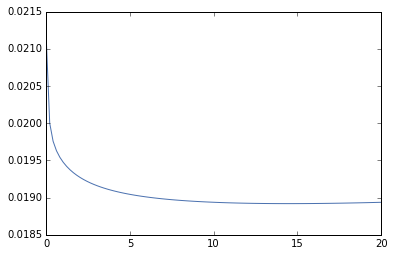

In [587]:
plt.plot(alpha_grid, err)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

### Lasso regression

In [618]:
alpha, err, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, X_test, y_test, 
                                   alpha_min=10**(-10000), alpha_max=20, RegressionClass=lm.Lasso)

In [619]:
alpha

0.0

In [620]:
las = lm.Lasso(alpha = alpha)
las.fit(X_train_new, y_train_new)
y_pred = las.predict(X_test)

MSE_las = np.mean((y_pred - y_test)**2)
MSE_las

0.02321571498280051

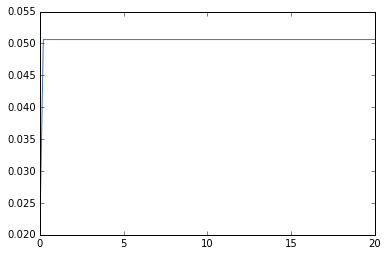

In [621]:
plt.plot(alpha_grid, err)
plt.show()

In [622]:
# выведем доверительный интервал
print(meme[-1] - MSE_las, meme[-1] + MSE_las)

[ 0.21476322] [ 0.26119465]


__Итог:__ Оптимальный гиперпараметр (=штраф) для Lasso=0, то есть Lasso предсказывает так же, как и обычная линейная регрессия. Лучше пользоваться Ridge.

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

обозначим new_features - номера признаков отобранных с помощью Lasso

In [629]:
new_features = a

In [630]:
X_train_shrinked = X_train.iloc[:,new_features]
X_validate_shrinked = X_validate.iloc[:,new_features]
X_test_shrinked = X_test.iloc[:,new_features]
X_train_new_shrinked = X_train_new[:,new_features]

In [631]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.001, 1, 10)
gamma_grid = np.linspace(0.001, 1, 10)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_shrinked)
        X_validate_rbf = RBF.transform(X_validate_shrinked)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma

In [632]:
alpha_best

0.66700000000000004

In [633]:
gamma_best

0.223

Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

In [635]:
RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
X_train_RBF = RBF.fit_transform(X_train_new_shrinked, y_train_new)
X_test_RBF = RBF.transform(X_test_shrinked)

In [639]:
Ridge = lm.Ridge(alpha=alpha_best)
Ridge.fit(X_train_RBF, y_train_new)

Ridge(alpha=0.66700000000000004, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [643]:
y_pred_RRID = Ridge.predict(X_test_RBF)
MSE_RRID = np.mean((y_pred_RRID - y_test)**2)

In [644]:
print(MSE_lin, MSE_rid, MSE_las, MSE_RRID)

0.02337934930210532 0.019434585078724538 0.02321571498280051 0.01849675875450466


__Итог:__ Наименьшая среднеквадратичная ошибка у Ridge регрессии с использованием приближения ядер RBF! :)